In [1]:
import pandas as pd
import numpy as np
import os
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
from copy import deepcopy as dc
import transformers
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch import cat
from langchain_openai import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity

if not os.environ.get("OPENAI_API_KEY"):
    import key
    key.init()
assert os.environ.get('OPENAI_API_KEY')

path_human = './eval_data/human_aug21.xlsx'
n = 5 # number of rewordings to do
temp = 0
model = 'gpt-4o'

human = pd.read_excel(path_human).drop(['annotator', 'src'], axis=1)
human.head()

,query,variable,temporal resolution,start year,end year,MIP,experiment
0,What is a relevant variable for surface air te...,tas,NaN,NaN,NaN,NaN,NaN
1,What variable can help me understand summer Ar...,siconca,NaN,NaN,NaN,NaN,NaN
2,What are some datasets relevant to extreme wea...,"pr, ua, etc",NaN,NaN,NaN,NaN,NaN
3,"Plot the 10, 20, 50, and 100 yr return period ...",pr,day,NaN,NaN,historical,NaN
4,Show me all the times where Ames Iowa has more...,tas,day,1980.0,2014.0,CMIP,historical


In [2]:
human['experiment']

0            NaN
1            NaN
2            NaN
3            NaN
4     historical
5            NaN
6            NaN
7            NaN
8           amip
9            NaN
10           NaN
11        ssp585
12           NaN
13           NaN
14           NaN
15           NaN
16        ssp245
17    historical
18        ssp245
19           NaN
20    historical
21    historical
22        ssp245
23        ssp370
24    historical
25        ssp370
26    historical
27        ssp585
28        ssp370
29    historical
30        ssp126
31    historical
32        ssp370
33    historical
34        ssp370
Name: experiment, dtype: object

In [3]:
human.describe()

,start year,end year
count,29.000000,27.000000
mean,2011.482759,1978.185185
std,70.623054,357.505787
min,1850.000000,205.000000
25%,1974.000000,2012.000000
50%,2020.000000,2050.000000
75%,2070.000000,2079.500000
max,2100.000000,2100.000000


In [4]:
human.isna().describe()

,query,variable,temporal resolution,start year,end year,MIP,experiment
count,35,35,35,35,35,35,35
unique,1,1,2,2,2,2,2
top,False,False,False,False,False,False,False
freq,35,35,29,29,27,30,21


# Augmentation

In [5]:
# temporal frequency agent
temporalmsg = f"""Reword the following sentence {n} different ways 
without changing meaning. Return each rewording on a new line 
with no additional markings (bullet points, dashes, etc.)
"""
temporalprompt = ChatPromptTemplate.from_messages([('system', temporalmsg), ('human', '{question}')])
llm=ChatOpenAI(temperature=temp, model=model, )
temporalagent = temporalprompt | llm 
# print(temporalagent.invoke('plot average yearly rainfall 2010-2014').content)

In [6]:
dfs = [] # will have 1 df per human query, containing its rephrases
for i, row in human.iterrows():
    print(i)
    qrows = []
    query = row['query']
    rewords = temporalagent.invoke(query).content.split('\n')
    if len(rewords) != n:
        print(f'query has {len(rewords)}:', query)

    newrows = pd.DataFrame([dc(row) for j in range(n+1)]).reset_index(drop=True)
    newrows['id'] = newrows.apply(lambda x: str(i)+'.'+str(x.name), axis=1)
    newrows.loc[1:, 'query'] = rewords
    dfs.append(newrows)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34


In [7]:
data = pd.concat(dfs).reset_index(drop=True)
data.head(n=n+2)

,query,variable,temporal resolution,start year,end year,MIP,experiment,id
0,What is a relevant variable for surface air te...,tas,NaN,NaN,NaN,NaN,NaN,0.0
1,Which variable is pertinent to surface air tem...,tas,NaN,NaN,NaN,NaN,NaN,0.1
2,What factor is significant for surface air tem...,tas,NaN,NaN,NaN,NaN,NaN,0.2
3,What is an important variable for surface air ...,tas,NaN,NaN,NaN,NaN,NaN,0.3
4,Which variable is relevant to surface air temp...,tas,NaN,NaN,NaN,NaN,NaN,0.4
5,What is a key variable for surface air tempera...,tas,NaN,NaN,NaN,NaN,NaN,0.5
6,What variable can help me understand summer Ar...,siconca,NaN,NaN,NaN,NaN,NaN,1.0


In [8]:
data.shape

(210, 8)

In [9]:
# data.to_excel('./eval_data/augment_aug21.xlsx')

# Cosine distances

In [10]:
scibert = transformers.AutoModel.from_pretrained('allenai/scibert_scivocab_uncased')
tokenizer = transformers.BertTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')
openai_emb_model = OpenAIEmbeddings(model="text-embedding-3-large")

In [11]:
dl = DataLoader(data['query'], batch_size=4)
embs_scibert = []
for i, batch in enumerate(tqdm(dl)):
    embbatch = scibert(**tokenizer(batch, padding='longest', return_tensors='pt'))['pooler_output']
    embs_scibert.append(embbatch)
embs_scibert = cat(embs_scibert).detach().numpy()
sims_scibert = cosine_similarity(embs_scibert)

  0%|          | 0/53 [00:00<?, ?it/s]

In [12]:
embs_openai = np.asarray(openai_emb_model.embed_documents(data['query']))
sims_openai = cosine_similarity(embs_openai)

products
- plot of distance each child query has to parent
- heatmap for one human query: distance of its children versus of others' children to it https://seaborn.pydata.org/examples/heat_scatter.html

In [13]:
# sims[::n+1] # get every n+1th row (every row corresponding to a human query)
simlist_scibert = [] # i-th element is list of i-th query's childrens' similarities to itself
simlist_openai = [] #ditto
for i in range(len(human)):
    human_i = i*(n+1)
    child_s = i*(n+1) + 1
    child_e = i*(n+1) + 1+n
    simlist_scibert.append(sims_scibert[human_i, child_s:child_e])
    simlist_openai.append(sims_openai[human_i, child_s:child_e])

In [14]:
from matplotlib import pyplot as plt 



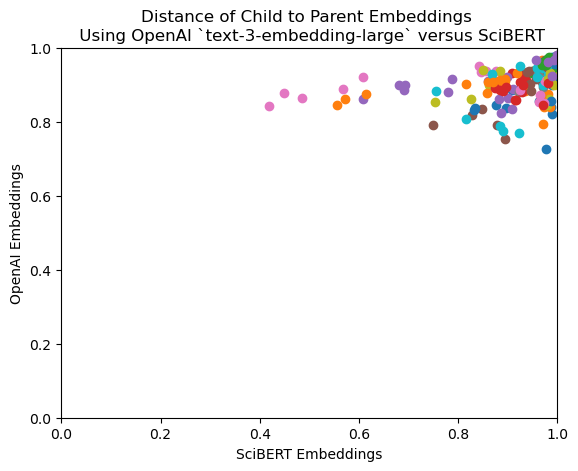

In [15]:
axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
axes.set_xlabel('SciBERT Embeddings')
axes.set_ylabel('OpenAI Embeddings')

for i in range(len(human)):
    plt.scatter(simlist_scibert[i], simlist_openai[i], marker='o', )
plt.title('Distance of Child to Parent Embeddings \n Using OpenAI `text-3-embedding-large` versus SciBERT')
plt.savefig('/Users/snc/r/nasa/augscatter.png')

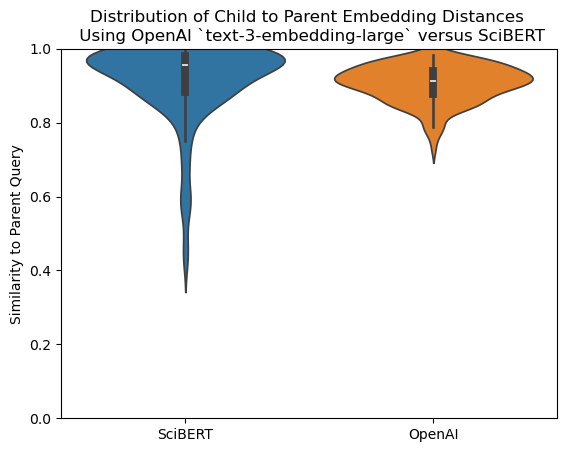

In [16]:
import seaborn as sns 

axes = plt.gca()
axes.set_xlim([0,1])
axes.set_ylim([0,1])
# axes.set_xlabel('SciBERT')
axes.set_ylabel('Similarity to Parent Query')

# https://seaborn.pydata.org/generated/seaborn.violinplot.html
flat_scibert = [item for sublist in simlist_scibert for item in sublist]
flat_openai = [item for sublist in simlist_openai for item in sublist]
violinin = pd.DataFrame.from_records([flat_scibert, flat_openai], index=['SciBERT', 'OpenAI']).T
sns.violinplot(violinin, ax=axes)
plt.title('Distribution of Child to Parent Embedding Distances \n Using OpenAI `text-3-embedding-large` versus SciBERT')
plt.savefig('/Users/snc/r/nasa/augviolin.png')